# Build LSTM model

## Read data

In [ ]:
import os
from pathlib import Path

import pandas as pd


dataDirName = Path(os.environ['DATA_DIR'], 'sepsis_prediction', 'lstm_initial_trials', '02_data_matrix', 'imbalanced_data')
dataDirName.mkdir(exist_ok=True, parents=True)

dataDf = pd.read_csv(Path(dataDirName, 'data_1_variable.csv'))
dataDf = dataDf.sort_values(by=['PATIENT_ID', 'EPISODE_ID', 'measurement_datetime'], ascending=True)
dataDf

,PATIENT_ID,EPISODE_ID,measurement_datetime,concept_name,value_mean,Organism_FIRST_NOTED,sepsis,target
0,18849,12790706,2019-09-01,Temperature,37.477778,2019-09-01,0.0,0.0
1,18849,12790706,2019-09-02,Temperature,36.875000,2019-09-01,0.0,0.0
2,18849,12790706,2019-09-03,Temperature,36.750000,2019-09-01,0.0,0.0
3,41308,14824675,2021-05-29,Temperature,36.576819,2021-05-31,0.0,0.0
4,41308,14824675,2021-05-30,Temperature,36.576819,2021-05-31,0.0,0.0
...,...,...,...,...,...,...,...,...
228981,2684042,17565390,2023-03-31,Temperature,36.576819,2023-04-01,0.0,0.0
228982,2684042,17565390,2023-04-01,Temperature,36.100000,2023-04-01,0.0,0.0
228983,2684042,17565632,2023-03-30,Temperature,36.576819,2023-04-01,0.0,0.0
228984,2684042,17565632,2023-03-31,Temperature,36.576819,2023-04-01,0.0,0.0


In [124]:
dataDf[dataDf.target == 1][200:210]

,PATIENT_ID,EPISODE_ID,measurement_datetime,concept_name,value_mean,Organism_FIRST_NOTED,sepsis,target
7015,309825,481728,2017-11-21,Temperature,36.576819,2017-11-05,1.0,1.0
7016,309825,481728,2017-11-22,Temperature,36.576819,2017-11-05,1.0,1.0
7017,309825,481728,2017-11-23,Temperature,36.000000,2017-11-05,1.0,1.0
7021,310094,499315,2018-01-23,Temperature,36.576819,2018-01-18,1.0,1.0
7022,310094,499315,2018-01-24,Temperature,36.576819,2018-01-18,1.0,1.0
7023,310094,499315,2018-01-25,Temperature,36.400000,2018-01-18,1.0,1.0
7041,311670,373021,2017-02-15,Temperature,36.576819,2017-01-02,1.0,1.0
7042,311670,373021,2017-02-16,Temperature,36.576819,2017-01-02,1.0,1.0
7043,311670,373021,2017-02-17,Temperature,36.000000,2017-01-02,1.0,1.0
7079,313406,13355118,2020-03-11,Temperature,37.514286,2020-03-11,1.0,1.0


In [125]:
rowsX = []
rowsY = []
for name, group in dataDf.groupby(by=['PATIENT_ID', 'EPISODE_ID']):
    low = 0
    high = 3
    while high <= group.shape[0]:
        rowsX.append([[x] for x in list(group.value_mean[low: high])])
        rowsY.append(group.target[(high - 1): high].values[0])
        high += 1
        low += 1

In [126]:
rowsX

[[[37.47777777777778], [36.875], [36.75]],
 [[36.57681874218282], [36.57681874218282], [29.9]],
 [[36.26666666666667], [36.73333333333333], [36.8]],
 [[36.73333333333333], [36.8], [21.65]],
 [[36.8], [21.65], [36.1]],
 [[21.65], [36.1], [36.35]],
 [[36.1], [36.35], [36.35]],
 [[36.35], [36.35], [36.93333333333333]],
 [[36.35], [36.93333333333333], [36.1]],
 [[36.93333333333333], [36.1], [36.650000000000006]],
 [[36.1], [36.650000000000006], [36.16666666666666]],
 [[36.650000000000006], [36.16666666666666], [36.6]],
 [[36.16666666666666], [36.6], [36.26666666666667]],
 [[36.6], [36.26666666666667], [36.46666666666667]],
 [[36.26666666666667], [36.46666666666667], [36.333333333333336]],
 [[36.46666666666667], [36.333333333333336], [36.53333333333333]],
 [[36.333333333333336], [36.53333333333333], [36.85]],
 [[36.53333333333333], [36.85], [36.53333333333333]],
 [[36.85], [36.53333333333333], [36.4]],
 [[36.53333333333333], [36.4], [36.375]],
 [[36.4], [36.375], [36.2]],
 [[36.375], [36.2]

In [127]:
import numpy as np


trainX = np.array(rowsX)
testX = np.array(rowsX)
trainY = np.array(rowsY)
testY = np.array(rowsY)


In [128]:
trainX.shape, trainY.shape

((189056, 3, 1), (189056,))

In [ ]:
# LSTM for international airline passengers problem with time step regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


look_back = 3

model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/10
189056/189056 - 178s - 942us/step - accuracy: 0.9454 - loss: 0.2125
Epoch 2/10
189056/189056 - 179s - 945us/step - accuracy: 0.9454 - loss: 0.2120
Epoch 3/10
189056/189056 - 177s - 936us/step - accuracy: 0.9454 - loss: 0.2121
Epoch 4/10
189056/189056 - 179s - 944us/step - accuracy: 0.9454 - loss: 0.2121
Epoch 5/10
189056/189056 - 180s - 950us/step - accuracy: 0.9454 - loss: 0.2120
Epoch 6/10
189056/189056 - 177s - 938us/step - accuracy: 0.9454 - loss: 0.2121
Epoch 7/10


KeyboardInterrupt: 

In [116]:
[x[0] for x in trainPredict]

[np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float3

In [117]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


print('accuracy_score', accuracy_score(trainY, [1 if (x[0] > 0.5) else 0 for x in trainPredict]))
print('balanced_accuracy_score', balanced_accuracy_score(trainY, [1 if (x[0] > 0.5) else 0 for x in trainPredict]))
print('precision_score', precision_score(trainY, [1 if (x[0] > 0.5) else 0 for x in trainPredict]))
print('recall_score', recall_score(trainY, [1 if (x[0] > 0.5) else 0 for x in trainPredict]))
print('precision_recall_fscore_support', precision_recall_fscore_support(trainY, [1 if (x[0] > 0.5) else 0 for x in trainPredict]))
print('f1_score', f1_score(trainY, [1 if (x[0] > 0.5) else 0 for x in trainPredict]))
print('roc_auc_score', roc_auc_score(trainY, [1 if (x[0] > 0.5) else 0 for x in trainPredict]))

accuracy_score 0.05459757955314827
balanced_accuracy_score 0.5
precision_score 0.05459757955314827
recall_score 1.0
precision_recall_fscore_support (array([0.        , 0.05459758]), array([0., 1.]), array([0.        , 0.10354202]), array([178734,  10322]))
f1_score 0.10354201566872975
roc_auc_score 0.5


/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Old code

2025-05-08 05:02:57.848473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 05:02:57.849479: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 05:02:57.852714: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 05:02:57.861286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746680577.876199  189781 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746680577.88

Epoch 1/100


2025-05-08 05:02:59.644253: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 - 1s - 10ms/step - loss: 0.0517
Epoch 2/100
92/92 - 0s - 1ms/step - loss: 0.0214
Epoch 3/100
92/92 - 0s - 1ms/step - loss: 0.0162
Epoch 4/100
92/92 - 0s - 1ms/step - loss: 0.0144
Epoch 5/100
92/92 - 0s - 1ms/step - loss: 0.0129
Epoch 6/100
92/92 - 0s - 1ms/step - loss: 0.0114
Epoch 7/100
92/92 - 0s - 1ms/step - loss: 0.0101
Epoch 8/100
92/92 - 0s - 1ms/step - loss: 0.0089
Epoch 9/100
92/92 - 0s - 1ms/step - loss: 0.0078
Epoch 10/100
92/92 - 0s - 1ms/step - loss: 0.0068
Epoch 11/100
92/92 - 0s - 1ms/step - loss: 0.0060
Epoch 12/100
92/92 - 0s - 1ms/step - loss: 0.0054
Epoch 13/100
92/92 - 0s - 1ms/step - loss: 0.0050
Epoch 14/100
92/92 - 0s - 1ms/step - loss: 0.0047
Epoch 15/100
92/92 - 0s - 1ms/step - loss: 0.0045
Epoch 16/100
92/92 - 0s - 1ms/step - loss: 0.0044
Epoch 17/100
92/92 - 0s - 1ms/step - loss: 0.0043
Epoch 18/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 19/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 20/100
92/92 - 0s - 1ms/step - loss: 0.0042
Epoch 21/100
92/92 -

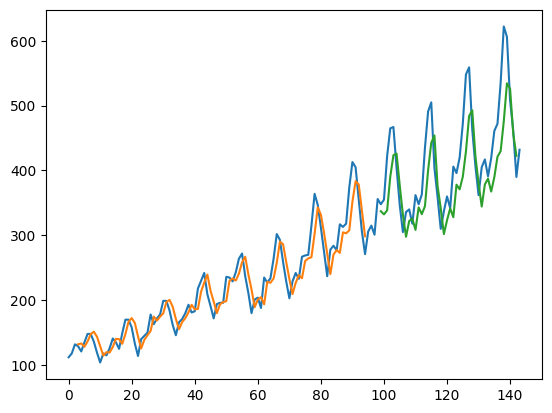

In [1]:
# LSTM for international airline passengers problem with time step regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [4]:
trainX

array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]],

       [[0.05405405],
        [0.04826255],
        [0.03281853]],

       [[0.04826255],
        [0.03281853],
        [0.05984557]],

       [[0.03281853],
        [0.05984557],
        [0.08494207]],

       [[0.05984557],
        [0.08494207],
        [0.08494207]],

       [[0.08494207],
        [0.08494207],
        [0.06177607]],

       [[0.08494207],
        [0.06177607],
        [0.02895753]],

       [[0.06177607],
        [0.02895753],
        [0.        ]],

       [[0.02895753],
        [0.        ],
        [0.02702703]],

       [[0.        ],
        [0.02702703],
        [0.02123553]],

       [[0.02702703],
        [0.02123553],
        [0.04247104]],

       [[0.02123553],
        [0.04247104],
        [0.07142857]],

       [[0.04247104],
        [0.07142857],
        [0.05984557]],

       [[0.07142857],
        [0.05984557],
    